# RapidPhase: GPU-Accelerated Phase Unwrapping Examples

This notebook demonstrates how to use `rapidphase` for GPU-accelerated phase unwrapping.
The package provides fast DCT and IRLS-based phase unwrapping with automatic GPU acceleration via PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rapidphase

# Check available devices
print("Available devices:", rapidphase.get_available_devices())

Available devices: {'cpu': True, 'cuda': True, 'mps': False, 'cuda_devices': [{'index': 0, 'name': 'NVIDIA A100-SXM4-80GB', 'total_memory': 85095874560, 'compute_capability': '8.0'}, {'index': 1, 'name': 'NVIDIA A100-SXM4-80GB', 'total_memory': 85095874560, 'compute_capability': '8.0'}, {'index': 2, 'name': 'NVIDIA A100-SXM4-80GB', 'total_memory': 85095874560, 'compute_capability': '8.0'}, {'index': 3, 'name': 'NVIDIA A100-SXM4-80GB', 'total_memory': 85095874560, 'compute_capability': '8.0'}, {'index': 4, 'name': 'NVIDIA A100-SXM4-80GB', 'total_memory': 85095874560, 'compute_capability': '8.0'}, {'index': 5, 'name': 'NVIDIA A100-SXM4-80GB', 'total_memory': 85095874560, 'compute_capability': '8.0'}, {'index': 6, 'name': 'NVIDIA A100-SXM4-80GB', 'total_memory': 85095874560, 'compute_capability': '8.0'}, {'index': 7, 'name': 'NVIDIA A100-SXM4-80GB', 'total_memory': 85095874560, 'compute_capability': '8.0'}]}


## Example 1: Basic Phase Unwrapping

Simulate a 512x512 interferogram containing a simple diagonal phase ramp with multiple fringes.

In [2]:
# Simulate a 512x512 interferogram containing a simple diagonal phase ramp
y, x = np.ogrid[-3:3:512j, -3:3:512j]
igram = np.exp(1j * np.pi * (x + y))

# Sample coherence for an interferogram with no noise
corr = np.ones(igram.shape, dtype=np.float32)

# Unwrap using default settings (auto-selects best algorithm)
unw, conncomp = rapidphase.unwrap(igram, corr, nlooks=1.0)

print(f"Input shape: {igram.shape}")
print(f"Unwrapped phase range: {unw.min():.2f} to {unw.max():.2f} radians")

Input shape: (512, 512)
Unwrapped phase range: -18.84 to 18.84 radians


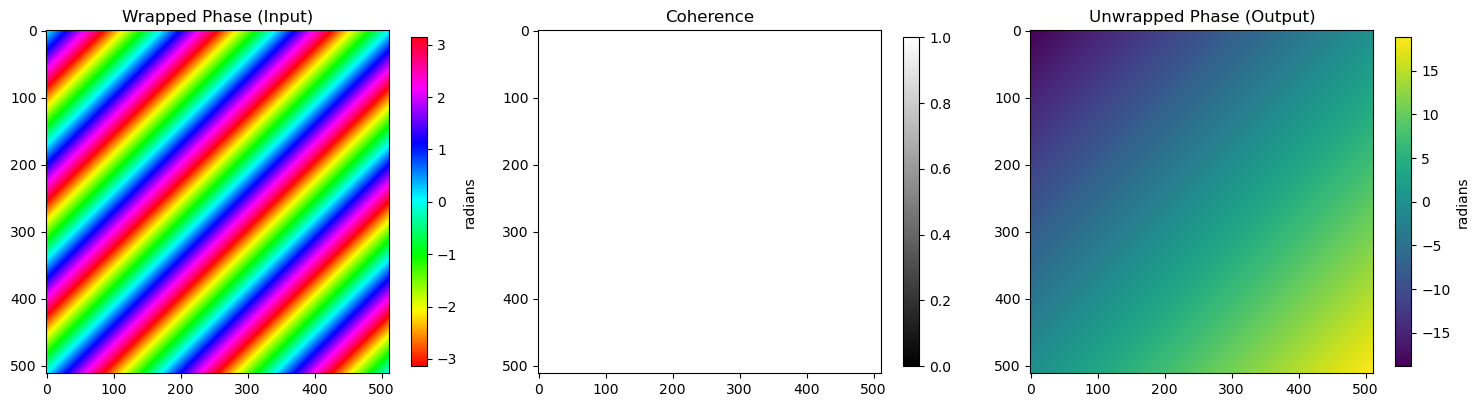

In [3]:
# Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Wrapped phase (input)
wrapped_phase = np.angle(igram)
im0 = axes[0].imshow(wrapped_phase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0].set_title('Wrapped Phase (Input)')
plt.colorbar(im0, ax=axes[0], label='radians', shrink=0.7)

# Coherence
im1 = axes[1].imshow(corr, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Coherence')
plt.colorbar(im1, ax=axes[1], shrink=0.7)

# Unwrapped phase (output)
im2 = axes[2].imshow(unw, cmap='viridis')
axes[2].set_title('Unwrapped Phase (Output)')
plt.colorbar(im2, ax=axes[2], label='radians', shrink=0.7)

plt.tight_layout()
plt.show()

## Example 2: Large Image with Tiled Processing

For large interferograms, use tiled processing to manage memory. This example simulates a 2048x2048 image.

The tiled processing includes:
- **Overlapping tiles**: Each tile extends beyond its core region for context
- **Phase alignment**: Automatic alignment of phase offsets between adjacent tiles using overlap regions
- **Feathered blending**: Smooth cosine-weighted blending at tile boundaries

In [4]:
# Simulate a 2048x2048 interferogram with many fringes
y, x = np.ogrid[-12:12:2048j, -12:12:2048j]
igram_large = np.exp(1j * np.pi * (x + y))

# Sample coherence
corr_large = np.ones(igram_large.shape, dtype=np.float32)

# Unwrap using a 4x4 grid of tiles with overlap
unw_large, conncomp_large = rapidphase.unwrap(
    igram_large, corr_large, 
    nlooks=1.0, 
    ntiles=(4, 4),      # 4x4 tile grid
    tile_overlap=256    # 256 pixel overlap between tiles
)

print(f"Input shape: {igram_large.shape}")
print(f"Unwrapped phase range: {unw_large.min():.2f} to {unw_large.max():.2f} radians")

Input shape: (2048, 2048)
Unwrapped phase range: -28.24 to 122.54 radians


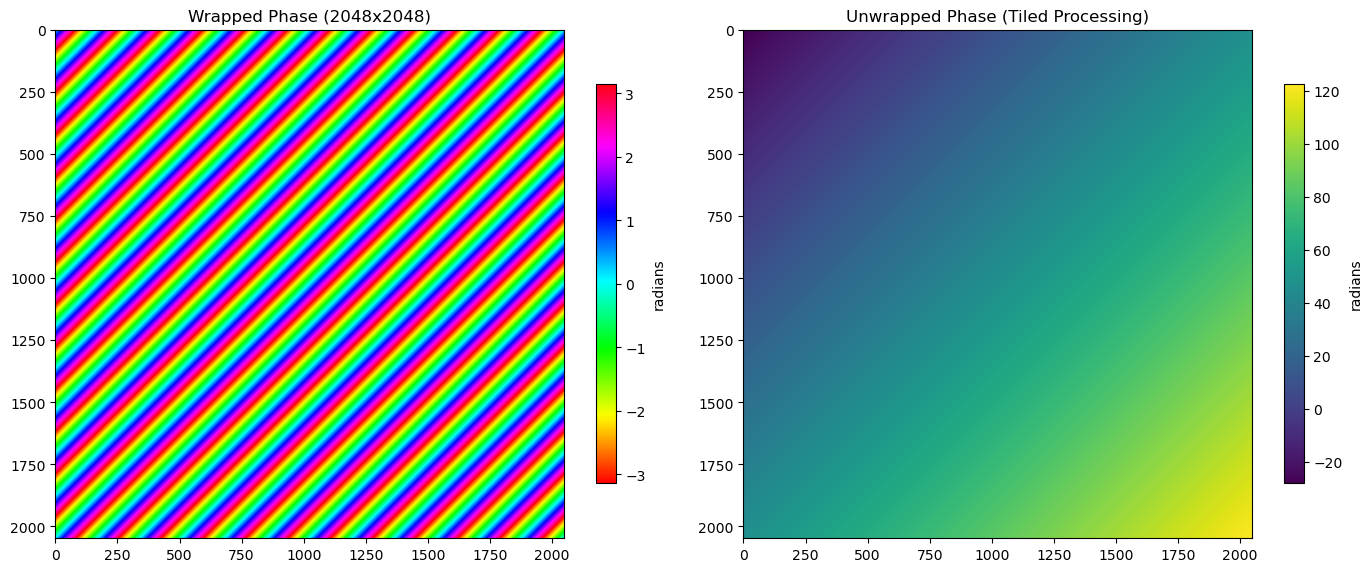

In [5]:
# Visualize large image results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wrapped phase
im0 = axes[0].imshow(np.angle(igram_large), cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0].set_title('Wrapped Phase (2048x2048)')
plt.colorbar(im0, ax=axes[0], label='radians', shrink=0.7)

# Unwrapped phase
im1 = axes[1].imshow(unw_large, cmap='viridis')
axes[1].set_title('Unwrapped Phase (Tiled Processing)')
plt.colorbar(im1, ax=axes[1], label='radians', shrink=0.7)

plt.tight_layout()
plt.show()

Correlation between tiled and reference: 1.000000
Maximum absolute difference: 23.584979 radians


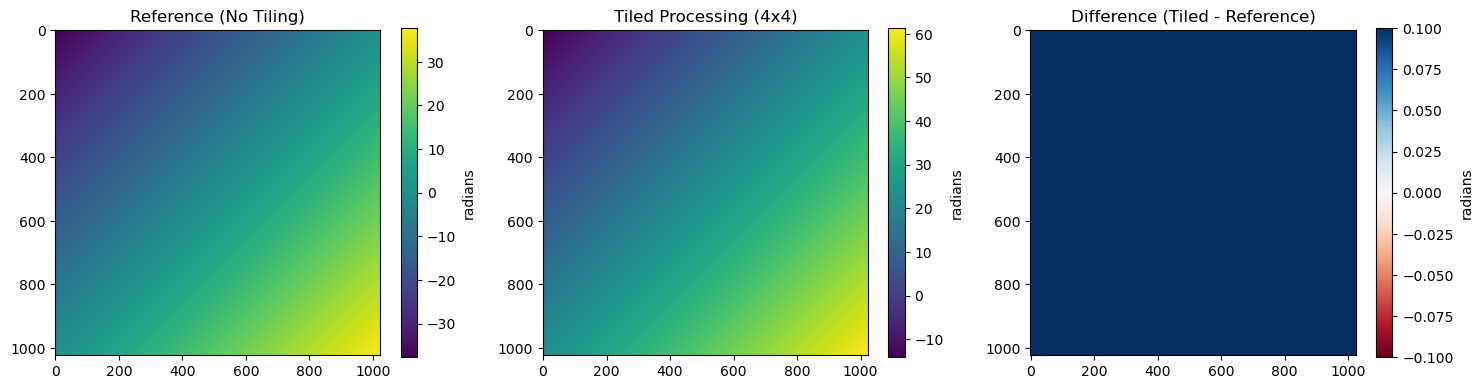

In [6]:
# Compare tiled vs non-tiled processing to verify seamless merging
# Use a smaller image for faster comparison
y, x = np.ogrid[-6:6:1024j, -6:6:1024j]
igram_test = np.exp(1j * np.pi * (x + y))
corr_test = np.ones(igram_test.shape, dtype=np.float32)

# Unwrap without tiling (reference)
unw_ref, _ = rapidphase.unwrap(igram_test, corr_test, nlooks=1.0)

# Unwrap with tiling (4x4 grid)
unw_tiled, _ = rapidphase.unwrap(
    igram_test, corr_test, 
    nlooks=1.0, 
    ntiles=(4, 4),
    tile_overlap=128
)

# Calculate correlation between tiled and reference
correlation = np.corrcoef(unw_ref.flatten(), unw_tiled.flatten())[0, 1]
max_diff = np.abs(unw_ref - unw_tiled).max()

print(f"Correlation between tiled and reference: {correlation:.6f}")
print(f"Maximum absolute difference: {max_diff:.6f} radians")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(unw_ref, cmap='viridis')
axes[0].set_title('Reference (No Tiling)')
plt.colorbar(im0, ax=axes[0], label='radians', shrink=0.7)

im1 = axes[1].imshow(unw_tiled, cmap='viridis')
axes[1].set_title('Tiled Processing (4x4)')
plt.colorbar(im1, ax=axes[1], label='radians', shrink=0.7)

# Show difference (should be nearly zero)
diff = unw_tiled - unw_ref
im2 = axes[2].imshow(diff, cmap='RdBu', vmin=-0.1, vmax=0.1)
axes[2].set_title('Difference (Tiled - Reference)')
plt.colorbar(im2, ax=axes[2], label='radians', shrink=0.7)

plt.tight_layout()
plt.show()

## Example 3: DCT vs IRLS Algorithms

Compare the two available algorithms:
- **DCT**: Fast unweighted least-squares (best for high-coherence data)
- **IRLS**: Iteratively reweighted least-squares (uses coherence for weighting)

In [7]:
# Create interferogram with varying coherence
y, x = np.ogrid[-3:3:512j, -3:3:512j]
igram = np.exp(1j * np.pi * (x + y))

# Create coherence map with low-coherence region in center
corr = 0.95 - 0.7 * np.exp(-((x)**2 + (y)**2) / 0.5)
corr = np.clip(corr, 0.2, 1.0).astype(np.float32)

# Unwrap with DCT (fast, unweighted)
unw_dct, _ = rapidphase.unwrap_dct(igram)

# Unwrap with IRLS (coherence-weighted)
unw_irls, _ = rapidphase.unwrap_irls(igram, corr, nlooks=5.0)

print("DCT unwrapping completed")
print("IRLS unwrapping completed")

DCT unwrapping completed
IRLS unwrapping completed


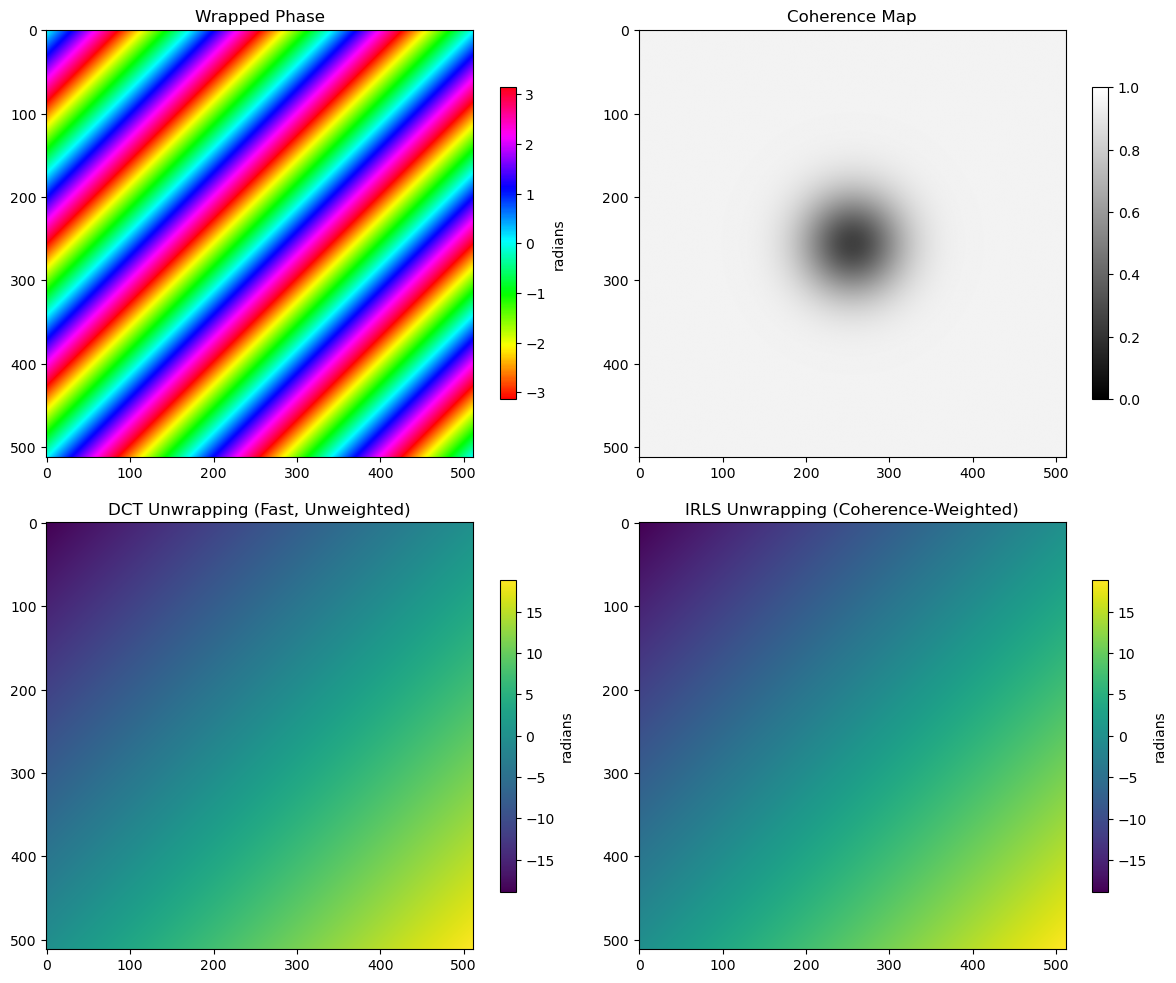

In [8]:
# Compare algorithms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Wrapped phase
im00 = axes[0, 0].imshow(np.angle(igram), cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_title('Wrapped Phase')
plt.colorbar(im00, ax=axes[0, 0], label='radians', shrink=0.7)

# Coherence
im01 = axes[0, 1].imshow(corr, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('Coherence Map')
plt.colorbar(im01, ax=axes[0, 1], shrink=0.7)

# DCT result
im10 = axes[1, 0].imshow(unw_dct, cmap='viridis')
axes[1, 0].set_title('DCT Unwrapping (Fast, Unweighted)')
plt.colorbar(im10, ax=axes[1, 0], label='radians', shrink=0.7)

# IRLS result
im11 = axes[1, 1].imshow(unw_irls, cmap='viridis')
axes[1, 1].set_title('IRLS Unwrapping (Coherence-Weighted)')
plt.colorbar(im11, ax=axes[1, 1], label='radians', shrink=0.7)

plt.tight_layout()
plt.show()

## Example 4: Complex Interferogram Pattern

Create a more complex phase pattern (circular fringes) to test unwrapping.

In [9]:
# Create circular fringe pattern (simulating topographic phase)
y, x = np.ogrid[-5:5:512j, -5:5:512j]
r = np.sqrt(x**2 + y**2)

# Phase proportional to distance from center (like a cone)
true_phase = 3 * np.pi * r
igram_circle = np.exp(1j * true_phase)

# Coherence decreasing with distance
corr_circle = np.exp(-r / 5).astype(np.float32)
corr_circle = np.clip(corr_circle, 0.3, 1.0)

# Unwrap
unw_circle, _ = rapidphase.unwrap(igram_circle, corr_circle, nlooks=5.0)

print(f"True phase range: {true_phase.min():.2f} to {true_phase.max():.2f}")
print(f"Unwrapped phase range: {unw_circle.min():.2f} to {unw_circle.max():.2f}")

True phase range: 0.13 to 66.64
Unwrapped phase range: -35.86 to 30.38


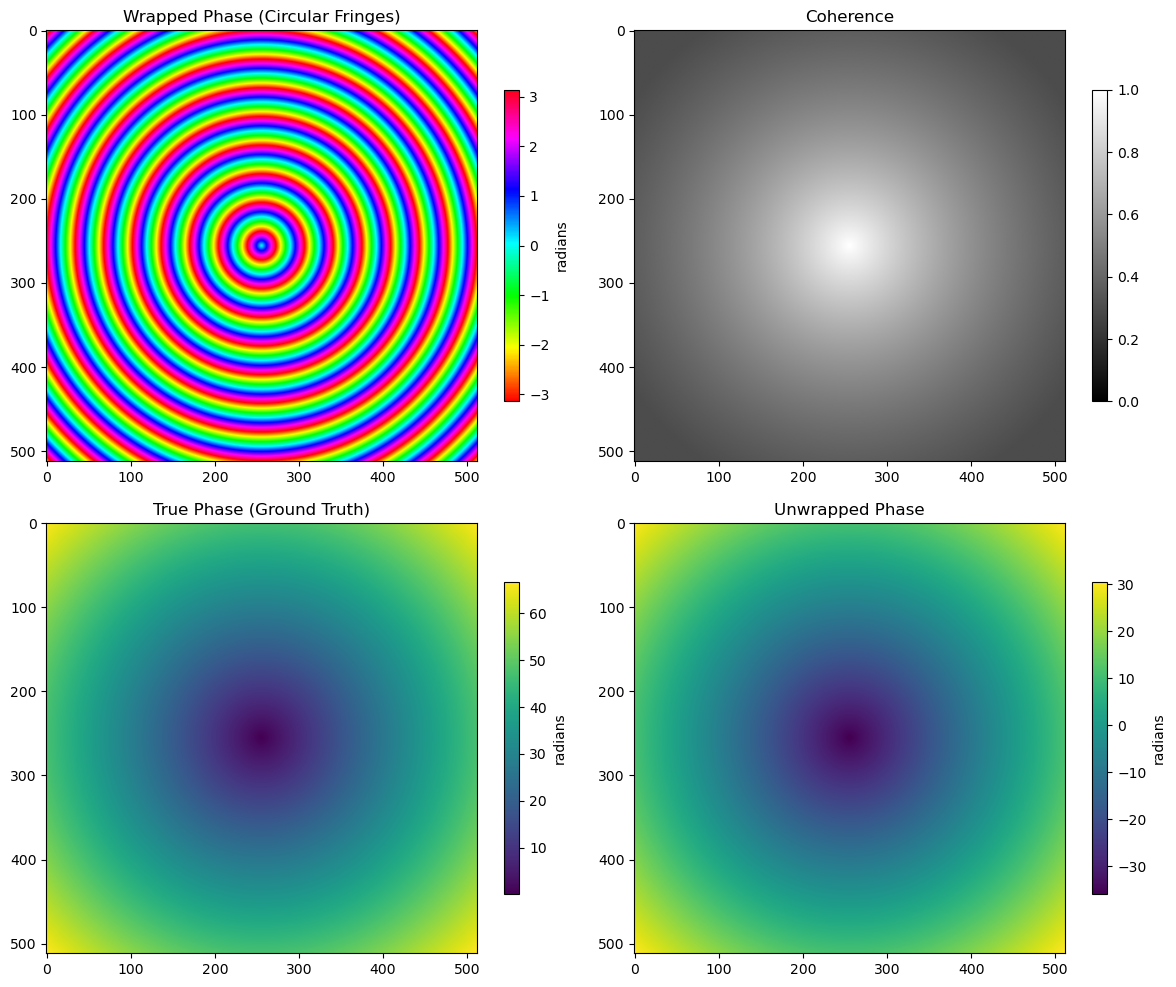

In [10]:
# Visualize circular pattern
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Wrapped phase
im00 = axes[0, 0].imshow(np.angle(igram_circle), cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_title('Wrapped Phase (Circular Fringes)')
plt.colorbar(im00, ax=axes[0, 0], label='radians', shrink=0.7)

# Coherence
im01 = axes[0, 1].imshow(corr_circle, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('Coherence')
plt.colorbar(im01, ax=axes[0, 1], shrink=0.7)

# True phase
im10 = axes[1, 0].imshow(true_phase, cmap='viridis')
axes[1, 0].set_title('True Phase (Ground Truth)')
plt.colorbar(im10, ax=axes[1, 0], label='radians', shrink=0.7)

# Unwrapped phase
im11 = axes[1, 1].imshow(unw_circle, cmap='viridis')
axes[1, 1].set_title('Unwrapped Phase')
plt.colorbar(im11, ax=axes[1, 1], label='radians', shrink=0.7)

plt.tight_layout()
plt.show()

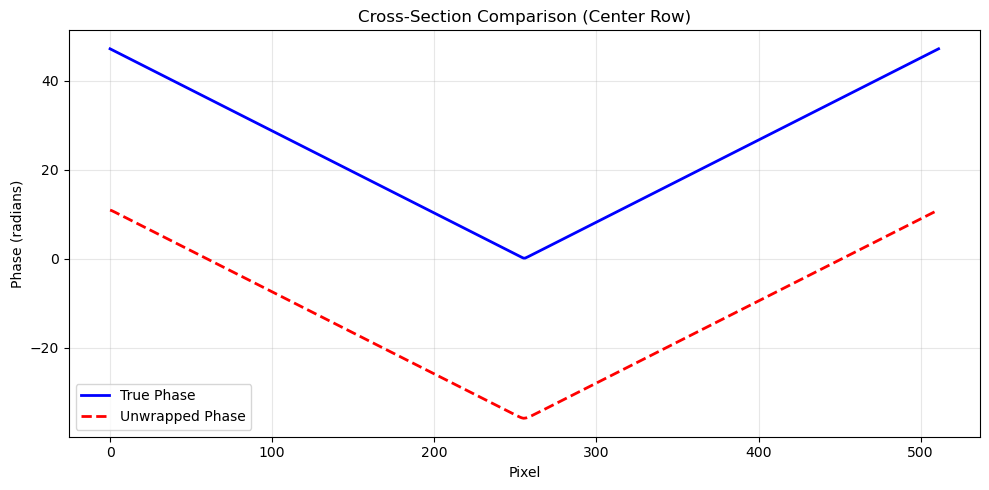

Correlation with true phase: 1.000000


In [11]:
# Compare cross-sections
center = 256

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(true_phase[center, :], 'b-', label='True Phase', linewidth=2)
ax.plot(unw_circle[center, :], 'r--', label='Unwrapped Phase', linewidth=2)
ax.set_xlabel('Pixel')
ax.set_ylabel('Phase (radians)')
ax.set_title('Cross-Section Comparison (Center Row)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
corr_coef = np.corrcoef(true_phase.flatten(), unw_circle.flatten())[0, 1]
print(f"Correlation with true phase: {corr_coef:.6f}")

## Example 5: Noisy Interferogram

Test unwrapping with added phase noise.

In [12]:
# Create interferogram with noise
y, x = np.ogrid[-3:3:512j, -3:3:512j]
true_phase = np.pi * (x + y)

# Add noise
np.random.seed(42)
noise_level = 0.5  # radians
noisy_phase = true_phase + noise_level * np.random.randn(*true_phase.shape)
igram_noisy = np.exp(1j * noisy_phase)

# Coherence inversely related to noise
corr_noisy = (0.9 * np.ones_like(true_phase)).astype(np.float32)

# Unwrap with both methods
unw_dct_noisy, _ = rapidphase.unwrap_dct(igram_noisy)
unw_irls_noisy, _ = rapidphase.unwrap_irls(igram_noisy, corr_noisy, nlooks=10.0)

print("Unwrapping of noisy interferogram completed")

Unwrapping of noisy interferogram completed


## Example 5b: Goldstein Adaptive Filter for Noise Reduction

Before phase unwrapping, applying an adaptive filter can significantly reduce noise and improve unwrapping quality. The **Goldstein filter** is a frequency-domain adaptive filter that:

- Enhances signal in regions with strong fringes
- Suppresses noise in regions with weak signal
- Preserves fringe structure while smoothing noise

The filter strength is controlled by `alpha` (0.2-1.0, higher = stronger filtering) and `window_size` (typically 32-64 pixels).

In [13]:
# Apply Goldstein filter to noisy interferogram before unwrapping
# Using the same noisy interferogram from Example 5

# Apply Goldstein filter with default parameters (alpha=0.6, window_size=64)
igram_filtered = rapidphase.goldstein_filter(igram_noisy, alpha=0.6, window_size=64)

print("Goldstein filter applied")
print(f"Original phase noise std: {np.std(np.angle(igram_noisy) - true_phase):.3f} rad")

# Compare gradient magnitudes (measure of smoothness)
orig_grad = np.gradient(np.angle(igram_noisy))
filt_grad = np.gradient(np.angle(igram_filtered))
orig_grad_mag = np.sqrt(orig_grad[0]**2 + orig_grad[1]**2)
filt_grad_mag = np.sqrt(filt_grad[0]**2 + filt_grad[1]**2)

print(f"Original gradient std: {np.std(orig_grad_mag):.3f}")
print(f"Filtered gradient std: {np.std(filt_grad_mag):.3f}")

Goldstein filter applied
Original phase noise std: 7.920 rad
Original gradient std: 0.950
Filtered gradient std: 0.463


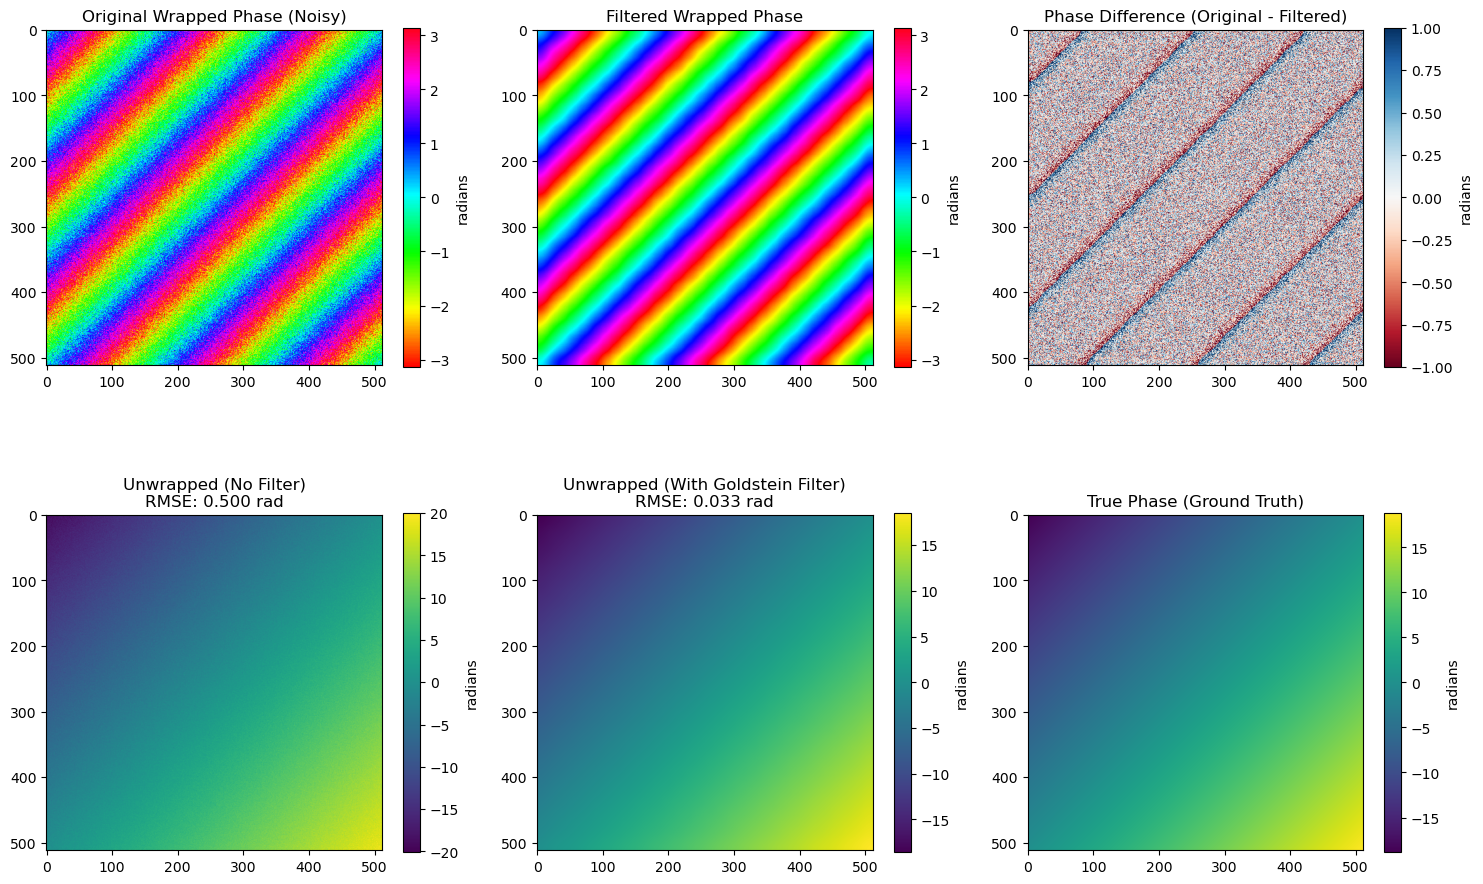


Unwrapping quality comparison:
  Without filter RMSE: 0.5003 rad
  With Goldstein filter RMSE: 0.0330 rad


In [14]:
# Visualize original vs filtered interferogram
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Phase comparison
im00 = axes[0, 0].imshow(np.angle(igram_noisy), cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_title('Original Wrapped Phase (Noisy)')
plt.colorbar(im00, ax=axes[0, 0], label='radians', shrink=0.7)

im01 = axes[0, 1].imshow(np.angle(igram_filtered), cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 1].set_title('Filtered Wrapped Phase')
plt.colorbar(im01, ax=axes[0, 1], label='radians', shrink=0.7)

# Phase difference
phase_diff = np.angle(igram_noisy) - np.angle(igram_filtered)
im02 = axes[0, 2].imshow(phase_diff, cmap='RdBu', vmin=-1, vmax=1)
axes[0, 2].set_title('Phase Difference (Original - Filtered)')
plt.colorbar(im02, ax=axes[0, 2], label='radians', shrink=0.7)

# Row 2: Unwrap filtered and compare with unfiltered
unw_filtered, _ = rapidphase.unwrap_dct(igram_filtered)

# Normalize for comparison
unw_noisy_n = unw_dct_noisy - np.mean(unw_dct_noisy)
unw_filtered_n = unw_filtered - np.mean(unw_filtered)
true_phase_n = true_phase - np.mean(true_phase)

im10 = axes[1, 0].imshow(unw_dct_noisy, cmap='viridis')
axes[1, 0].set_title(f'Unwrapped (No Filter)\nRMSE: {np.sqrt(np.mean((unw_noisy_n - true_phase_n)**2)):.3f} rad')
plt.colorbar(im10, ax=axes[1, 0], label='radians', shrink=0.7)

im11 = axes[1, 1].imshow(unw_filtered, cmap='viridis')
axes[1, 1].set_title(f'Unwrapped (With Goldstein Filter)\nRMSE: {np.sqrt(np.mean((unw_filtered_n - true_phase_n)**2)):.3f} rad')
plt.colorbar(im11, ax=axes[1, 1], label='radians', shrink=0.7)

im12 = axes[1, 2].imshow(true_phase, cmap='viridis')
axes[1, 2].set_title('True Phase (Ground Truth)')
plt.colorbar(im12, ax=axes[1, 2], label='radians', shrink=0.7)

plt.tight_layout()
plt.show()

print(f"\nUnwrapping quality comparison:")
print(f"  Without filter RMSE: {np.sqrt(np.mean((unw_noisy_n - true_phase_n)**2)):.4f} rad")
print(f"  With Goldstein filter RMSE: {np.sqrt(np.mean((unw_filtered_n - true_phase_n)**2)):.4f} rad")

## Example 6: Comparison with SNAPHU (snaphu-py)

Compare RapidPhase results with the reference SNAPHU implementation via snaphu-py.

**Key Differences:**
- **SNAPHU**: Statistical-cost network flow algorithm (L0/L1 optimization)
- **RapidPhase**: DCT/IRLS least-squares methods (L2 optimization with optional reweighting)

SNAPHU is designed to handle discontinuities (e.g., fault lines), while RapidPhase excels at smooth deformation fields.

In [15]:
import snaphu
import time

# Create test interferogram: smooth diagonal ramp (256x256 for speed)
y, x = np.ogrid[-3:3:256j, -3:3:256j]
true_phase = np.pi * (x + y)
igram_compare = np.exp(1j * true_phase)
corr_compare = np.ones(igram_compare.shape, dtype=np.float32)

# Wrapped phase for input
wrapped_compare = np.angle(igram_compare)

print("Comparing phase unwrapping methods on 256x256 smooth ramp...")
print("=" * 60)

# 1. RapidPhase DCT
t0 = time.time()
unw_fp_dct, _ = rapidphase.unwrap_dct(igram_compare)
t_fp_dct = time.time() - t0
print(f"RapidPhase DCT:     {t_fp_dct:.4f}s")

# 2. RapidPhase IRLS (Jacobi)
t0 = time.time()
unw_fp_irls, _ = rapidphase.unwrap_irls(igram_compare, corr_compare, nlooks=1.0)
t_fp_irls = time.time() - t0
print(f"RapidPhase IRLS:    {t_fp_irls:.4f}s")

# 3. RapidPhase IRLS-CG (Conjugate Gradient)
t0 = time.time()
unw_fp_cg, _ = rapidphase.unwrap_irls_cg(igram_compare, corr_compare, nlooks=1.0)
t_fp_cg = time.time() - t0
print(f"RapidPhase IRLS-CG: {t_fp_cg:.4f}s")

# 4. SNAPHU (via snaphu-py)
t0 = time.time()
unw_snaphu, _ = snaphu.unwrap(igram_compare, corr_compare, nlooks=1.0)
t_snaphu = time.time() - t0
print(f"SNAPHU:            {t_snaphu:.4f}s")

print("=" * 60)

Comparing phase unwrapping methods on 256x256 smooth ramp...
RapidPhase DCT:     0.0055s
RapidPhase IRLS:    0.0123s
RapidPhase IRLS-CG: 0.1439s

snaphu v2.0.7
22 parameters input from file /tmp/tmpkmdl_do0/snaphu.config.rhbq9n_4.txt (22 lines total)
Reading wrapped phase from file /tmp/tmpkmdl_do0/snaphu.igram.pj_1_qhf.c8
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpkmdl_do0/snaphu.corr.q2nsthsk.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 0
Flow increment: 1  (Total improvements: 0)
Found 1 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpkmdl_do0/snaphu.conncomp.6xadzsjx.u4 as 4-byte unsigned ints
Maximum flow on network: 0
Total solution cost: 0
Integrating phase
Writing output to file /tmp/tmpkmdl_do0/snaphu.unw.tf0ivpc5.f4
Program snaphu done
Elapsed processor time: 

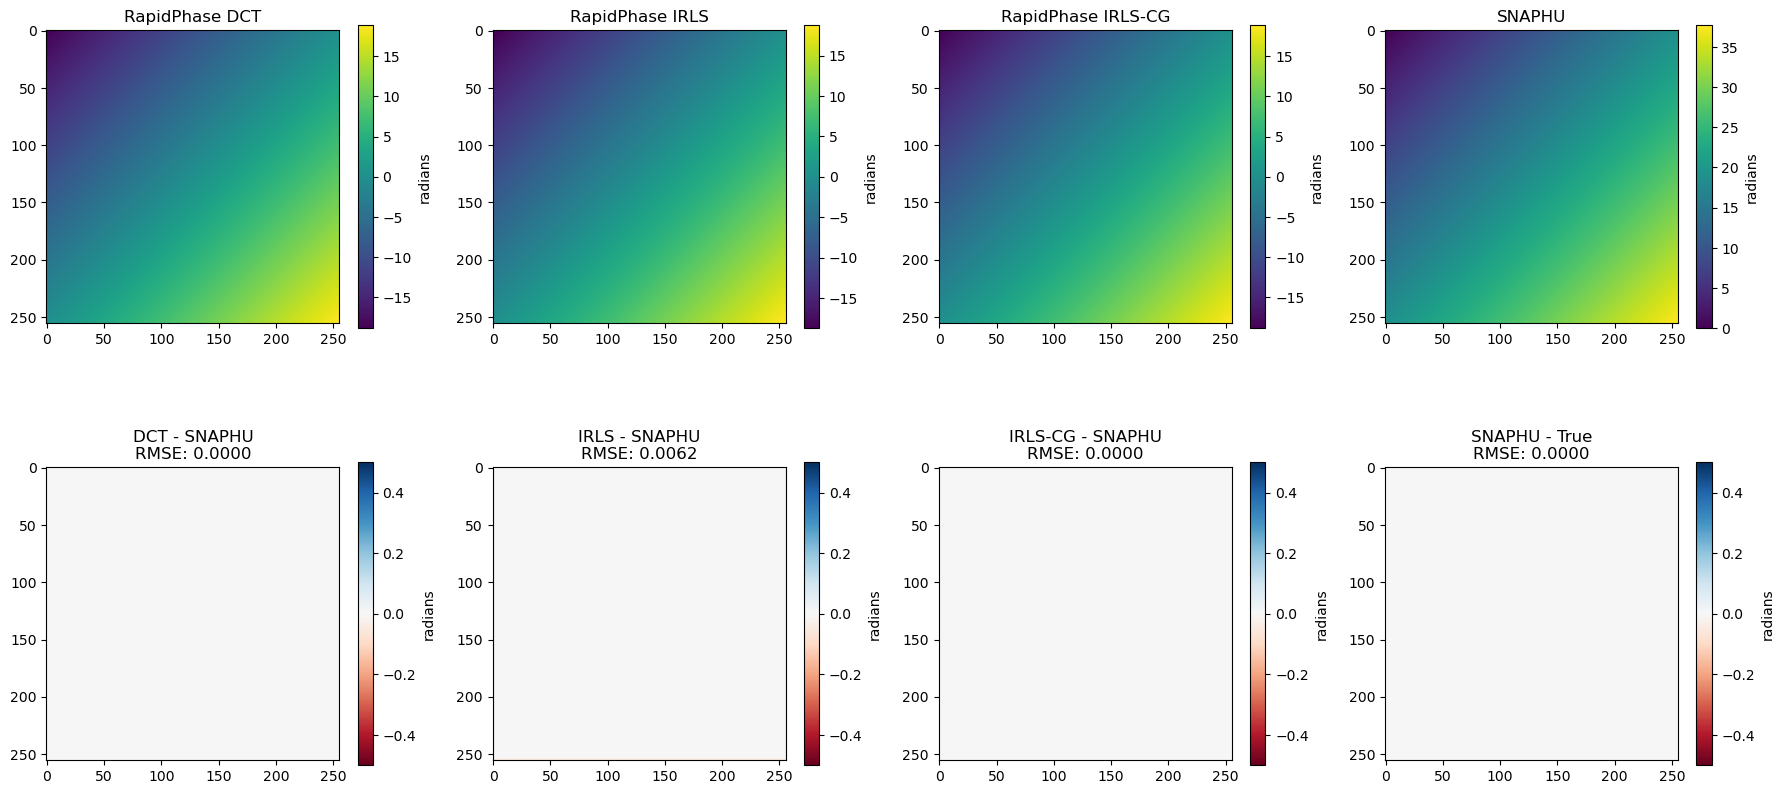

In [16]:
# Visualize comparison
fig, axes = plt.subplots(2, 4, figsize=(18, 9))

# Row 1: Unwrapped results
im00 = axes[0, 0].imshow(unw_fp_dct, cmap='viridis')
axes[0, 0].set_title('RapidPhase DCT')
plt.colorbar(im00, ax=axes[0, 0], label='radians', shrink=0.7)

im01 = axes[0, 1].imshow(unw_fp_irls, cmap='viridis')
axes[0, 1].set_title('RapidPhase IRLS')
plt.colorbar(im01, ax=axes[0, 1], label='radians', shrink=0.7)

im02 = axes[0, 2].imshow(unw_fp_cg, cmap='viridis')
axes[0, 2].set_title('RapidPhase IRLS-CG')
plt.colorbar(im02, ax=axes[0, 2], label='radians', shrink=0.7)

im03 = axes[0, 3].imshow(unw_snaphu, cmap='viridis')
axes[0, 3].set_title('SNAPHU')
plt.colorbar(im03, ax=axes[0, 3], label='radians', shrink=0.7)

# Row 2: Differences from SNAPHU
# Normalize to same mean for fair comparison
unw_fp_dct_norm = unw_fp_dct - np.mean(unw_fp_dct) + np.mean(unw_snaphu)
unw_fp_irls_norm = unw_fp_irls - np.mean(unw_fp_irls) + np.mean(unw_snaphu)
unw_fp_cg_norm = unw_fp_cg - np.mean(unw_fp_cg) + np.mean(unw_snaphu)

diff_dct = unw_fp_dct_norm - unw_snaphu
diff_irls = unw_fp_irls_norm - unw_snaphu
diff_cg = unw_fp_cg_norm - unw_snaphu

im10 = axes[1, 0].imshow(diff_dct, cmap='RdBu', vmin=-0.5, vmax=0.5)
axes[1, 0].set_title(f'DCT - SNAPHU\nRMSE: {np.sqrt(np.mean(diff_dct**2)):.4f}')
plt.colorbar(im10, ax=axes[1, 0], label='radians', shrink=0.7)

im11 = axes[1, 1].imshow(diff_irls, cmap='RdBu', vmin=-0.5, vmax=0.5)
axes[1, 1].set_title(f'IRLS - SNAPHU\nRMSE: {np.sqrt(np.mean(diff_irls**2)):.4f}')
plt.colorbar(im11, ax=axes[1, 1], label='radians', shrink=0.7)

im12 = axes[1, 2].imshow(diff_cg, cmap='RdBu', vmin=-0.5, vmax=0.5)
axes[1, 2].set_title(f'IRLS-CG - SNAPHU\nRMSE: {np.sqrt(np.mean(diff_cg**2)):.4f}')
plt.colorbar(im12, ax=axes[1, 2], label='radians', shrink=0.7)

# True phase comparison
diff_snaphu_true = unw_snaphu - np.mean(unw_snaphu) - (true_phase - np.mean(true_phase))
im13 = axes[1, 3].imshow(diff_snaphu_true, cmap='RdBu', vmin=-0.5, vmax=0.5)
axes[1, 3].set_title(f'SNAPHU - True\nRMSE: {np.sqrt(np.mean(diff_snaphu_true**2)):.4f}')
plt.colorbar(im13, ax=axes[1, 3], label='radians', shrink=0.7)

plt.tight_layout()
plt.show()


Quantitative Metrics (normalized to zero mean):
Correlation with true phase:
  RapidPhase DCT:     1.000000
  RapidPhase IRLS:    1.000000
  RapidPhase IRLS-CG: 1.000000
  SNAPHU:            1.000000

RMSE vs true phase (radians):
  RapidPhase DCT:     0.000000
  RapidPhase IRLS:    0.006241
  RapidPhase IRLS-CG: 0.000000
  SNAPHU:            0.000034


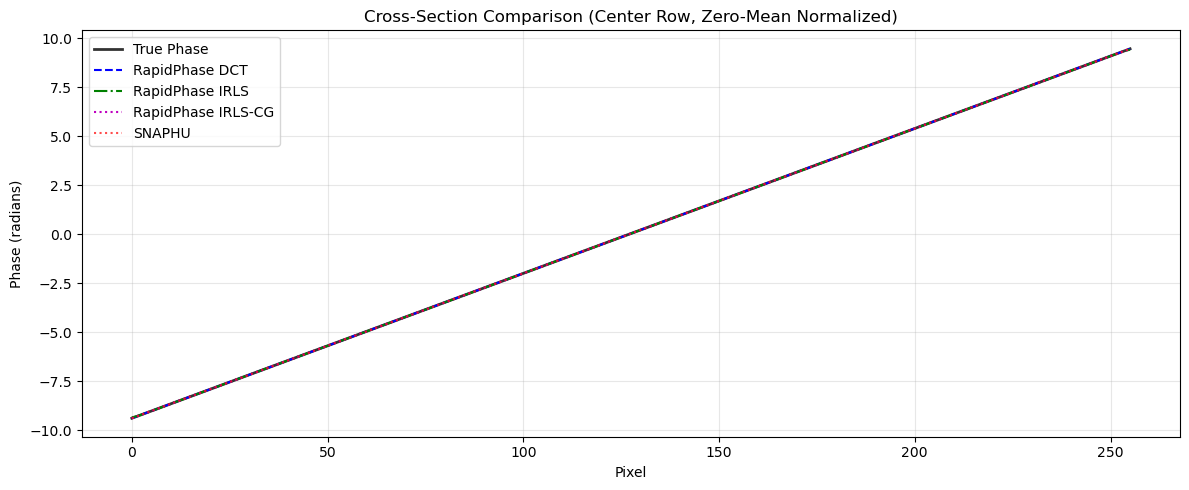


For smooth phase ramps, all methods produce nearly identical results.
RapidPhase offers significant speed advantages for this use case.


In [17]:
# Quantitative comparison
print("\nQuantitative Metrics (normalized to zero mean):")
print("=" * 60)

# Normalize all to zero mean for gradient comparison
def normalize(arr):
    return arr - np.mean(arr)

unw_fp_dct_n = normalize(unw_fp_dct)
unw_fp_irls_n = normalize(unw_fp_irls)
unw_fp_cg_n = normalize(unw_fp_cg)
unw_snaphu_n = normalize(unw_snaphu)
true_phase_n = normalize(true_phase)

# Correlation with true phase
corr_dct = np.corrcoef(unw_fp_dct_n.flatten(), true_phase_n.flatten())[0, 1]
corr_irls = np.corrcoef(unw_fp_irls_n.flatten(), true_phase_n.flatten())[0, 1]
corr_cg = np.corrcoef(unw_fp_cg_n.flatten(), true_phase_n.flatten())[0, 1]
corr_snaphu = np.corrcoef(unw_snaphu_n.flatten(), true_phase_n.flatten())[0, 1]

print(f"Correlation with true phase:")
print(f"  RapidPhase DCT:     {corr_dct:.6f}")
print(f"  RapidPhase IRLS:    {corr_irls:.6f}")
print(f"  RapidPhase IRLS-CG: {corr_cg:.6f}")
print(f"  SNAPHU:            {corr_snaphu:.6f}")

# RMSE vs true phase
rmse_dct = np.sqrt(np.mean((unw_fp_dct_n - true_phase_n)**2))
rmse_irls = np.sqrt(np.mean((unw_fp_irls_n - true_phase_n)**2))
rmse_cg = np.sqrt(np.mean((unw_fp_cg_n - true_phase_n)**2))
rmse_snaphu = np.sqrt(np.mean((unw_snaphu_n - true_phase_n)**2))

print(f"\nRMSE vs true phase (radians):")
print(f"  RapidPhase DCT:     {rmse_dct:.6f}")
print(f"  RapidPhase IRLS:    {rmse_irls:.6f}")
print(f"  RapidPhase IRLS-CG: {rmse_cg:.6f}")
print(f"  SNAPHU:            {rmse_snaphu:.6f}")

# Cross-section comparison
center = 128
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(true_phase_n[center, :], 'k-', label='True Phase', linewidth=2, alpha=0.8)
ax.plot(unw_fp_dct_n[center, :], 'b--', label='RapidPhase DCT', linewidth=1.5)
ax.plot(unw_fp_irls_n[center, :], 'g-.', label='RapidPhase IRLS', linewidth=1.5)
ax.plot(unw_fp_cg_n[center, :], 'm:', label='RapidPhase IRLS-CG', linewidth=1.5)
ax.plot(unw_snaphu_n[center, :], 'r:', label='SNAPHU', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Pixel')
ax.set_ylabel('Phase (radians)')
ax.set_title('Cross-Section Comparison (Center Row, Zero-Mean Normalized)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("For smooth phase ramps, all methods produce nearly identical results.")
print("RapidPhase offers significant speed advantages for this use case.")

### Test with Noisy Data

Compare methods on noisier data where coherence weighting matters more.

Comparing methods on noisy data (256x256, noise_level=0.8)...
RapidPhase DCT:     0.0048s
RapidPhase IRLS:    0.0505s
RapidPhase IRLS-CG: 0.9065s

snaphu v2.0.7
22 parameters input from file /tmp/tmpl64l40d_/snaphu.config.96h92wzl.txt (22 lines total)
Reading wrapped phase from file /tmp/tmpl64l40d_/snaphu.igram.rfoe0tay.c8
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpl64l40d_/snaphu.corr.zsnf2dt8.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 1
Flow increment: 1  (Total improvements: 0)
Found 1 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpl64l40d_/snaphu.conncomp.n_v0fw5w.u4 as 4-byte unsigned ints
Maximum flow on network: 1
Total solution cost: 5939044
Integrating phase
Writing output to file /tmp/tmpl64l40d_/snaphu.unw.i2epc55y.f4
Program snaphu done
Elapsed processor

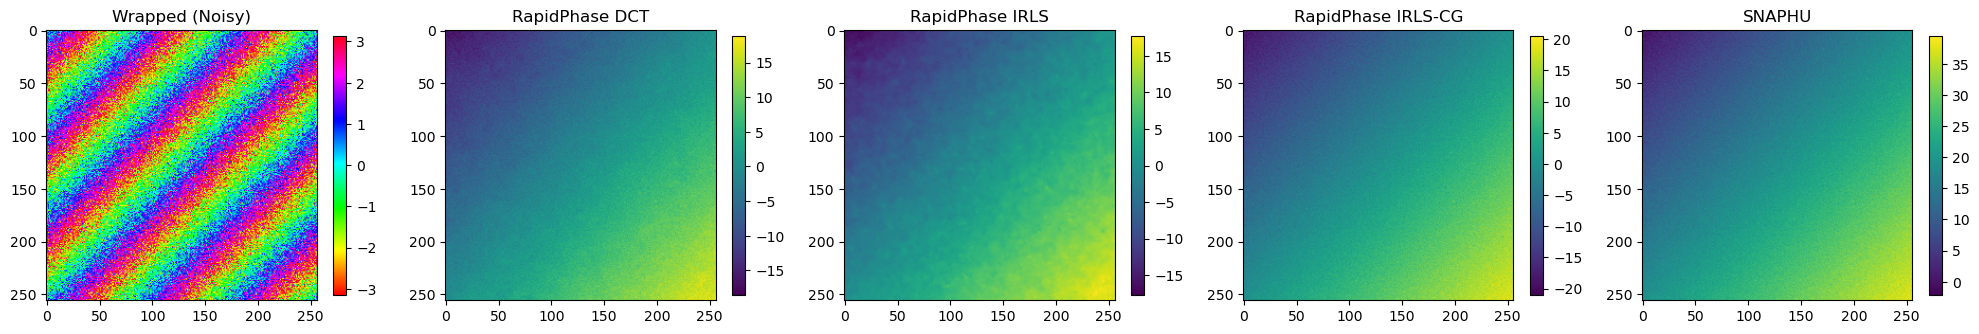

In [18]:
# Create noisy interferogram
np.random.seed(42)
y, x = np.ogrid[-3:3:256j, -3:3:256j]
true_phase_noisy = np.pi * (x + y)

# Add significant noise
noise_level = 0.8
noisy_phase = true_phase_noisy + noise_level * np.random.randn(*true_phase_noisy.shape)
igram_noisy_cmp = np.exp(1j * noisy_phase)

# Variable coherence (lower where noise is higher)
corr_noisy_cmp = 0.7 * np.ones_like(true_phase_noisy, dtype=np.float32)

print("Comparing methods on noisy data (256x256, noise_level=0.8)...")
print("=" * 60)

# RapidPhase DCT
t0 = time.time()
unw_fp_dct_noisy, _ = rapidphase.unwrap_dct(igram_noisy_cmp)
print(f"RapidPhase DCT:     {time.time() - t0:.4f}s")

# RapidPhase IRLS
t0 = time.time()
unw_fp_irls_noisy, _ = rapidphase.unwrap_irls(igram_noisy_cmp, corr_noisy_cmp, nlooks=5.0)
print(f"RapidPhase IRLS:    {time.time() - t0:.4f}s")

# RapidPhase IRLS-CG
t0 = time.time()
unw_fp_cg_noisy, _ = rapidphase.unwrap_irls_cg(igram_noisy_cmp, corr_noisy_cmp, nlooks=5.0)
print(f"RapidPhase IRLS-CG: {time.time() - t0:.4f}s")

# SNAPHU
t0 = time.time()
unw_snaphu_noisy, _ = snaphu.unwrap(igram_noisy_cmp, corr_noisy_cmp, nlooks=5.0)
print(f"SNAPHU:            {time.time() - t0:.4f}s")

# Normalize and compute metrics
unw_fp_dct_noisy_n = normalize(unw_fp_dct_noisy)
unw_fp_irls_noisy_n = normalize(unw_fp_irls_noisy)
unw_fp_cg_noisy_n = normalize(unw_fp_cg_noisy)
unw_snaphu_noisy_n = normalize(unw_snaphu_noisy)
true_phase_noisy_n = normalize(true_phase_noisy)

print("\nRMSE vs true phase (radians):")
print(f"  RapidPhase DCT:     {np.sqrt(np.mean((unw_fp_dct_noisy_n - true_phase_noisy_n)**2)):.4f}")
print(f"  RapidPhase IRLS:    {np.sqrt(np.mean((unw_fp_irls_noisy_n - true_phase_noisy_n)**2)):.4f}")
print(f"  RapidPhase IRLS-CG: {np.sqrt(np.mean((unw_fp_cg_noisy_n - true_phase_noisy_n)**2)):.4f}")
print(f"  SNAPHU:            {np.sqrt(np.mean((unw_snaphu_noisy_n - true_phase_noisy_n)**2)):.4f}")

# Visualize
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

im0 = axes[0].imshow(np.angle(igram_noisy_cmp), cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0].set_title('Wrapped (Noisy)')
plt.colorbar(im0, ax=axes[0], shrink=0.7)

im1 = axes[1].imshow(unw_fp_dct_noisy, cmap='viridis')
axes[1].set_title('RapidPhase DCT')
plt.colorbar(im1, ax=axes[1], shrink=0.7)

im2 = axes[2].imshow(unw_fp_irls_noisy, cmap='viridis')
axes[2].set_title('RapidPhase IRLS')
plt.colorbar(im2, ax=axes[2], shrink=0.7)

im3 = axes[3].imshow(unw_fp_cg_noisy, cmap='viridis')
axes[3].set_title('RapidPhase IRLS-CG')
plt.colorbar(im3, ax=axes[3], shrink=0.7)

im4 = axes[4].imshow(unw_snaphu_noisy, cmap='viridis')
axes[4].set_title('SNAPHU')
plt.colorbar(im4, ax=axes[4], shrink=0.7)

plt.tight_layout()
plt.show()

## Example 7: NISAR Interferogram

Apply phase unwrapping to a NISAR (NASA-ISRO Synthetic Aperture Radar) interferogram. This demonstrates performance on actual satellite data with complex phase patterns and varying coherence.

In [19]:
# Load NISAR interferogram data
nisar_phase = np.load('../npy/NISAR_phase.npy')
nisar_corr = np.load('../npy/NISAR_coherence.npy')

print(f"NISAR phase shape: {nisar_phase.shape}")
print(f"NISAR coherence shape: {nisar_corr.shape}")
print(f"Phase range: {nisar_phase.min():.2f} to {nisar_phase.max():.2f} radians")
print(f"Coherence range: {nisar_corr.min():.2f} to {nisar_corr.max():.2f}")

# Convert wrapped phase to complex interferogram
nisar_igram = np.exp(1j * nisar_phase)

NISAR phase shape: (6000, 4000)
NISAR coherence shape: (6000, 4000)
Phase range: -3.14 to 3.14 radians
Coherence range: 0.00 to 0.99


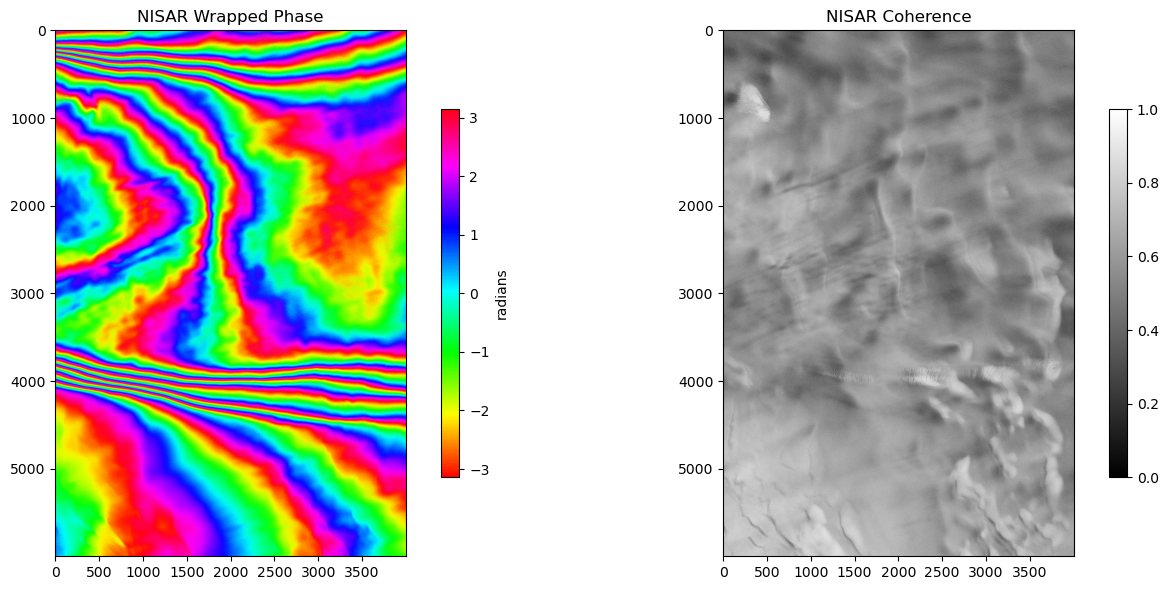


Coherence statistics:
  Mean: 0.576
  Std:  0.125
  Pixels with coherence > 0.5: 73.5%


In [20]:
# Visualize the NISAR input data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wrapped phase
im0 = axes[0].imshow(nisar_phase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0].set_title('NISAR Wrapped Phase')
plt.colorbar(im0, ax=axes[0], label='radians', shrink=0.7)

# Coherence
im1 = axes[1].imshow(nisar_corr, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('NISAR Coherence')
plt.colorbar(im1, ax=axes[1], shrink=0.7)

plt.tight_layout()
plt.show()

# Show coherence statistics
print(f"\nCoherence statistics:")
print(f"  Mean: {nisar_corr.mean():.3f}")
print(f"  Std:  {nisar_corr.std():.3f}")
print(f"  Pixels with coherence > 0.5: {(nisar_corr > 0.5).sum() / nisar_corr.size * 100:.1f}%")

In [21]:
# Unwrap NISAR interferogram using tiled processing
# This large image benefits from tiled processing for memory efficiency

print("Unwrapping NISAR interferogram with tiled processing...")
print("=" * 60)

# RapidPhase with tiled processing (6x4 grid to match aspect ratio)
t0 = time.time()
nisar_unw, nisar_conncomp = rapidphase.unwrap(
    nisar_igram, 
    nisar_corr, 
    nlooks=10.0,
    ntiles=(6, 4),
    tile_overlap=128
)
t_rapidphase = time.time() - t0
print(f"RapidPhase (tiled 6x4): {t_rapidphase:.2f}s")

print("=" * 60)
print(f"Unwrapped phase range: {nisar_unw.min():.2f} to {nisar_unw.max():.2f} radians")

Unwrapping NISAR interferogram with tiled processing...
RapidPhase (tiled 6x4): 4.78s
Unwrapped phase range: -28.56 to 53.69 radians


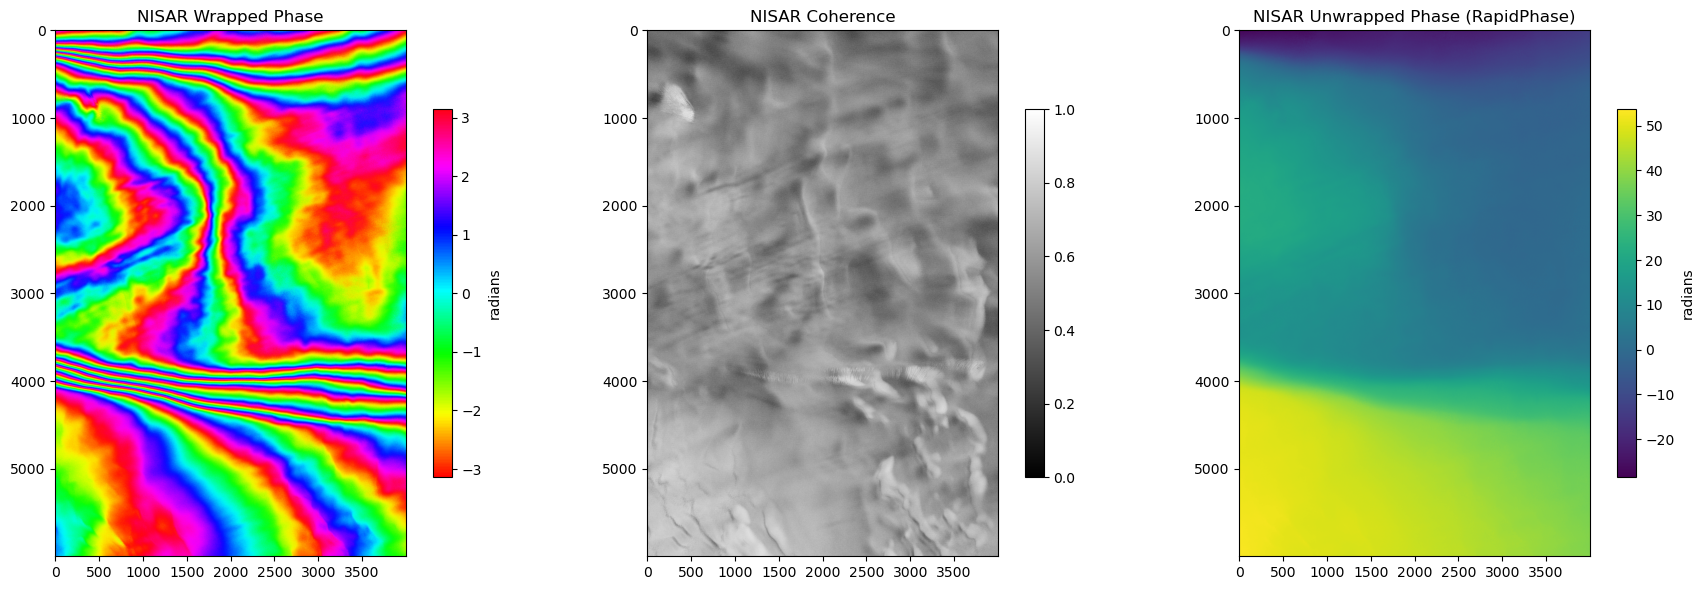

In [22]:
# Visualize NISAR unwrapping results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Wrapped phase
im0 = axes[0].imshow(nisar_phase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0].set_title('NISAR Wrapped Phase')
plt.colorbar(im0, ax=axes[0], label='radians', shrink=0.7)

# Coherence
im1 = axes[1].imshow(nisar_corr, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('NISAR Coherence')
plt.colorbar(im1, ax=axes[1], shrink=0.7)

# Unwrapped phase
im2 = axes[2].imshow(nisar_unw, cmap='viridis')
axes[2].set_title('NISAR Unwrapped Phase (RapidPhase)')
plt.colorbar(im2, ax=axes[2], label='radians', shrink=0.7)

plt.tight_layout()
plt.show()

### Compare RapidPhase vs SNAPHU on NISAR subset

For timing comparison, we'll use a 512x512 subset of the NISAR data.

In [23]:
# Extract a 512x512 subset from center for comparison
h, w = nisar_phase.shape
start_h, start_w = (h - 512) // 2, (w - 512) // 2
nisar_phase_sub = nisar_phase[start_h:start_h+512, start_w:start_w+512]
nisar_corr_sub = nisar_corr[start_h:start_h+512, start_w:start_w+512]
nisar_igram_sub = np.exp(1j * nisar_phase_sub)

print("Comparing methods on NISAR 512x512 subset...")
print("=" * 60)

# RapidPhase DCT
t0 = time.time()
unw_nisar_dct, _ = rapidphase.unwrap_dct(nisar_igram_sub)
print(f"RapidPhase DCT:     {time.time() - t0:.4f}s")

# RapidPhase IRLS
t0 = time.time()
unw_nisar_irls, _ = rapidphase.unwrap_irls(nisar_igram_sub, nisar_corr_sub, nlooks=10.0)
print(f"RapidPhase IRLS:    {time.time() - t0:.4f}s")

# RapidPhase IRLS-CG
t0 = time.time()
unw_nisar_cg, _ = rapidphase.unwrap_irls_cg(nisar_igram_sub, nisar_corr_sub, nlooks=10.0)
print(f"RapidPhase IRLS-CG: {time.time() - t0:.4f}s")

# SNAPHU
t0 = time.time()
unw_nisar_snaphu, _ = snaphu.unwrap(nisar_igram_sub, nisar_corr_sub, nlooks=10.0)
print(f"SNAPHU:            {time.time() - t0:.4f}s")

print("=" * 60)

Comparing methods on NISAR 512x512 subset...
RapidPhase DCT:     0.0167s
RapidPhase IRLS:    0.0643s
RapidPhase IRLS-CG: 0.0186s

snaphu v2.0.7
22 parameters input from file /tmp/tmp2kdm3x92/snaphu.config.fku8pdps.txt (22 lines total)
Reading wrapped phase from file /tmp/tmp2kdm3x92/snaphu.igram.91_21g7w.c8
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmp2kdm3x92/snaphu.corr.69mmlugd.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 0
Flow increment: 1  (Total improvements: 0)
Found 1 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmp2kdm3x92/snaphu.conncomp.ov35ft0g.u4 as 4-byte unsigned ints
Maximum flow on network: 0
Total solution cost: 860897
Integrating phase
Writing output to file /tmp/tmp2kdm3x92/snaphu.unw.hk3dpxqw.f4
Program snaphu done
Elapsed processor time:   0:00:00.6

## Summary

This notebook demonstrated the key features of `rapidphase`:

1. **Basic unwrapping** with `rapidphase.unwrap()`
2. **Tiled processing** for large images with `ntiles` and `tile_overlap`
   - Automatic phase alignment between tiles ensures seamless merging
   - Feathered blending at tile boundaries
3. **Algorithm selection**:
   - **DCT**: Fast unweighted least squares (O(n log n))
   - **IRLS**: Jacobi-based iterative reweighting (simple, GPU-friendly)
   - **IRLS-CG**: Conjugate Gradient solver (faster convergence, L1 approximation)
4. **Goldstein adaptive filtering** with `rapidphase.goldstein_filter()` for noise reduction before unwrapping
5. **Comparison with SNAPHU**: All RapidPhase methods produce comparable results on smooth data

### API Reference

```python
# Pre-processing: Goldstein adaptive filter (reduces noise before unwrapping)
filtered = rapidphase.goldstein_filter(
    igram,              # Complex interferogram
    alpha=0.6,          # Filter strength (0.2-1.0, higher = stronger)
    window_size=64,     # Window size in pixels (typically 32-64)
    overlap=0.75,       # Window overlap fraction
    device="auto",      # "cuda", "mps", "cpu", or "auto"
)

# Main unwrapping function
unw, conncomp = rapidphase.unwrap(
    igram,              # Complex interferogram or wrapped phase
    corr=None,          # Coherence map (optional)
    nlooks=1.0,         # Number of looks
    algorithm="auto",   # "dct", "irls", "irls_cg", or "auto"
    device="auto",      # "cuda", "mps", "cpu", or "auto"
    ntiles=None,        # Tile grid, e.g., (4, 4)
    tile_overlap=64,    # Overlap in pixels
)

# Convenience functions
unw, conncomp = rapidphase.unwrap_dct(igram)           # Fast DCT
unw, conncomp = rapidphase.unwrap_irls(igram, corr)    # Jacobi-based IRLS
unw, conncomp = rapidphase.unwrap_irls_cg(igram, corr) # CG-based IRLS (L1 approx)

# Device info
devices = rapidphase.get_available_devices()
```

### Algorithm Comparison

| Algorithm | Speed | Coherence Weighting | Best For |
|-----------|-------|---------------------|----------|
| DCT | Fastest | No | High-coherence data |
| IRLS | Medium | Yes (Huber-like) | General use |
| IRLS-CG | Medium | Yes (L1 approx) | Noisy data, outliers |
| SNAPHU | Slowest | Yes (statistical) | Discontinuities |

### Recommended Workflow

For noisy interferograms, apply filtering before unwrapping:

```python
# 1. Apply Goldstein filter to reduce noise
filtered = rapidphase.goldstein_filter(igram, alpha=0.6, window_size=64)

# 2. Unwrap the filtered interferogram
unw, conncomp = rapidphase.unwrap(filtered, corr, nlooks=5.0)
```